In [114]:
import sys
import logging
import random
import time

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import matplotlib.pyplot as plt
import cstrees.cstree as ct
import cstrees.scoring as sc
import cstrees.stage as st
import cstrees.learning as ctl
import cstrees.ldag as ldag
import networkx as nx
import numpy as np
import pp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example: Alarm

In [115]:
#import data:
alarmdf = pd.read_csv('../data/alarm_data.csv')
alarmdf = alarmdf.drop(columns = ['Unnamed: 0'],axis=1)

In [116]:
alarmnp = alarmdf.to_numpy()
alarmnp[:,0] = [0 for i in range(20000)]

def convertToNumeric(df):
    npdf = df.to_numpy()
    vars = list(df.columns)
    n = len(df)
    for v in vars:
        j = vars.index(v)
        states = list(alarmdf[v].drop_duplicates().to_numpy())
        for i in range(n):
            npdf[i,j] = states.index(alarmdf[v].iloc[i])
    numdf = pd.DataFrame(npdf)
    return numdf

numalarmdf = convertToNumeric(alarmdf)

cards_row = {0 : 3, 1 : 3, 2 : 2, 3 : 3, 4 : 3, 5 : 3, 6 : 3, 7 : 3, 8 : 3, 9 : 3, 10 : 3, 11 : 2, 12 : 4, 13 : 4, 14 : 4, 15 : 3, 16 : 2, 17 : 2, 18 : 2, 19 : 2, 20 : 2, 21 : 3, 22 : 2, 23 : 2, 24 : 3, 25 : 3, 26 : 2, 27 : 2, 28 : 3, 29 : 2, 30 : 2, 31 : 3, 32 : 3, 33 : 4, 34 : 4, 35 : 4, 36 : 4}
numalarmdf.loc[len(numalarmdf)] = cards_row
target_row = 20000
# Move target row to first element of list.
idx = [target_row] + [i for i in range(len(numalarmdf)) if i != target_row]
numalarmdf.iloc[idx]
numalarmdf_cards = numalarmdf.iloc[idx].reset_index(drop=True)
numalarmdf_cards.columns = alarmdf.columns

In [117]:
np.random.seed(1)
random.seed(1)
start = time.time()
pcgraph = pc(numalarmdf_cards[1:].values, 0.05, "chisq", node_names=numalarmdf_cards.columns)
poss_cvars = ctl.causallearn_graph_to_posscvars(pcgraph, labels=numalarmdf_cards.columns)
#print("Possible context variables per node:", poss_cvars)

score_table, context_scores, context_counts = sc.order_score_tables(numalarmdf_cards,
                                                                    max_cvars=2,
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=poss_cvars)

orders, scores = ctl.gibbs_order_sampler(5000, score_table)
end = time.time()
print('Computation time in seconds:', end - start)

Gibbs order sampler: 100%|██████████| 5000/5000 [00:02<00:00, 2105.28it/s]

Computation time in seconds: 9.686940908432007


In [118]:
# optimal variable ordering
alarmmaporder = orders[scores.index(max(scores))]
#print(alarmmaporder)

In [119]:
# get optimal tree for ordering
alarmopttree = ctl._optimal_cstree_given_order(alarmmaporder, context_scores)

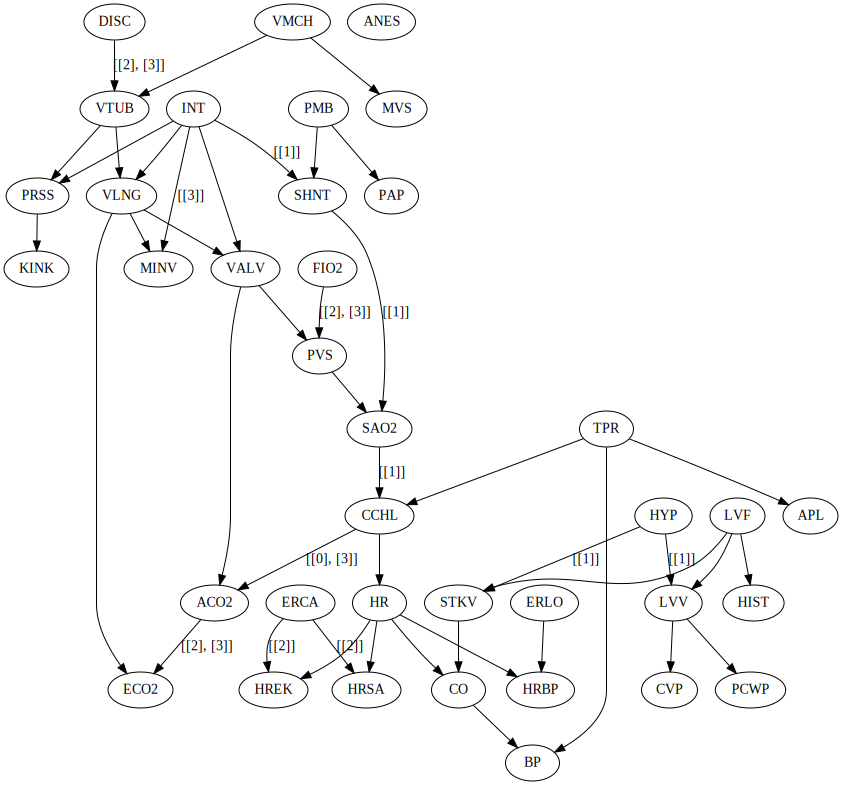

In [121]:
LDAG = ldag.get_LDAG(alarmopttree, varorder=alarmmaporder)
agraph = ldag.plot_LDAG(LDAG)
agraph
#agraph.draw('alarm_CStree_LDAG.png')